In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../../..")
from analysis_functions import *

In [4]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [6]:
component_num = 0

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error


# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = DecisionTreeRegressor(
    random_state=RANDOM_STATE, max_depth=10, min_samples_split=2
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = root_mean_squared_error(cur_y_test, cur_y_pred)
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = root_mean_squared_error(cur_y_train, cur_y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")

RMSE test: 9.12
RMSE train: 8.83


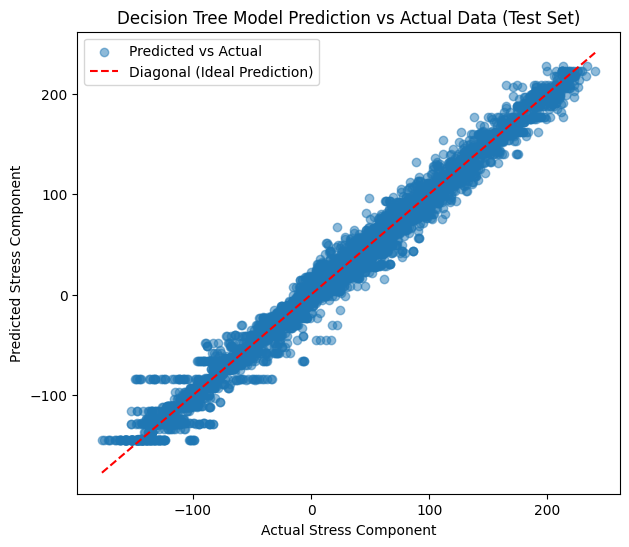

In [8]:
# Plotting the results on the test set
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Decision Tree Model Prediction vs Actual Data (Test Set)")
plt.legend()
plt.show()

## Добавляю кросс-валидацию

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score


n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)


def do_optuna_for_tree(X, y, n_trials=100, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_decision_tree_val(trial):
        max_depth = trial.suggest_int("max_depth", 1, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 32)

        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = DecisionTreeRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = (
            val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6
        )  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_decision_tree_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value


# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_tree(X, y, n_splits=n_splits)
# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = root_mean_squared_error(cur_y_test, cur_y_pred)
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_test)
rmse_train = root_mean_squared_error(cur_y_test, cur_y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")


[I 2025-05-08 01:24:17,395] A new study created in memory with name: no-name-ac86a8b3-da27-4b82-8f07-1ff797db58fb
[I 2025-05-08 01:24:17,532] Trial 6 finished with value: 17.45786758289325 and parameters: {'max_depth': 6, 'min_samples_split': 9}. Best is trial 6 with value: 17.45786758289325.
[I 2025-05-08 01:24:17,569] Trial 5 finished with value: 12.468486729895107 and parameters: {'max_depth': 8, 'min_samples_split': 2}. Best is trial 5 with value: 12.468486729895107.
[I 2025-05-08 01:24:17,579] Trial 0 finished with value: 9.898409840664163 and parameters: {'max_depth': 10, 'min_samples_split': 9}. Best is trial 0 with value: 9.898409840664163.
[I 2025-05-08 01:24:17,588] Trial 3 finished with value: 9.429020732570821 and parameters: {'max_depth': 29, 'min_samples_split': 27}. Best is trial 3 with value: 9.429020732570821.
[I 2025-05-08 01:24:17,588] Trial 4 finished with value: 9.164471662087207 and parameters: {'max_depth': 20, 'min_samples_split': 23}. Best is trial 4 with value

Best Hyperparameters: {'max_depth': 27, 'min_samples_split': 6}
RMSE test: 9.19
RMSE train: 9.19


### Сохраняю модель

In [10]:
import joblib

# Train the model with the best hyperparameters
best_model = DecisionTreeRegressor(
    random_state=RANDOM_STATE, 
    max_depth=best_params['max_depth'], 
    min_samples_split=best_params['min_samples_split']
)
best_model.fit(cur_X_train, cur_y_train)

# Save the model
joblib.dump(best_model, 'best_decision_tree_model.pkl')

# Predict using the best model
cur_y_pred_best = best_model.predict(cur_X_test)

# Evaluate the best model
rmse_best = root_mean_squared_error(cur_y_test, cur_y_pred_best)
print(f"RMSE test with best model: {rmse_best:.2f}")

# On train set
cur_y_pred_train_best = best_model.predict(cur_X_train)
rmse_train_best = root_mean_squared_error(cur_y_train, cur_y_pred_train_best)
print(f"RMSE train with best model: {rmse_train_best:.2f}")

RMSE test with best model: 6.32
RMSE train with best model: 2.63


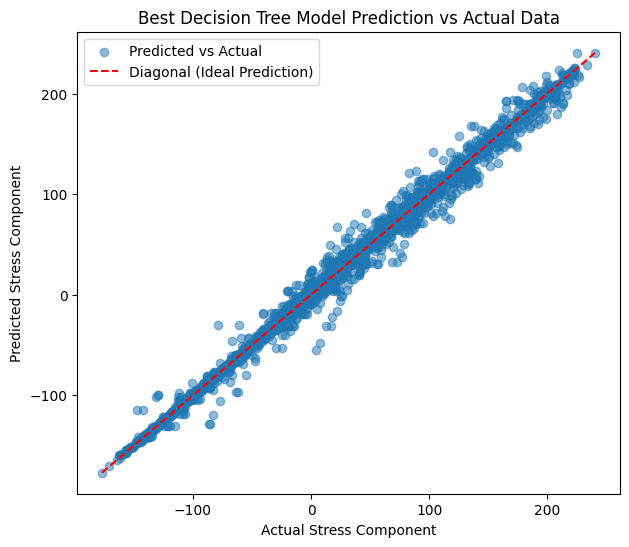

In [11]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred_best, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Best Decision Tree Model Prediction vs Actual Data")
plt.legend()
plt.show()